## 프로젝트 개요
플라즈마 이상 신호를 진단하기 위해 광 신호를 활용하는 센서를 개발 중입니다.

![플라즈마 이미지](image/project/plasma.jpg)

PMT 소자를 활용하여 플라즈마에서 방출된 photon을 electron으로 변환하여 세기를 측정하는 방식입니다.

데이터 형식은 1차원 배열로, 센서에서는 두 가지 형태의 데이터를 생성합니다:
1. **Streaming Data**: 초당 10,000,000 포인트를 생성합니다.
2. **Trend Data**: 초당 200 포인트를 생성하며, Streaming Data에서 최소값, 최대값, 평균을 50,000 포인트마다 샘플링하여 생성합니다.

현재 데이터의 양이 많아서 사람이 수동으로 데이터를 확인하고 있습니다.

두 데이터 모두 양이 많아서 사람이 수동으로 확인하기 어렵습니다.

이번 교육을 통해 머신러닝/딥러닝을 활용하여 센서 데이터를 학습하여 진단 결과를 도출하는 모델을 개발하고자 합니다.

---
### 만드려는 센서 신호 데이터 정의

센서 데이터는 회사 보안으로 인한 반출 문제로 센서 데이터를 생성해야 합니다.

만드려는 센서 신호의 세기는 0 ~ 5 값이며, 값은 소수점 형태로 (10 points/s) 최대한 실제 데이터와 비슷하게 만들었습니다.

총 7개 이며 신호는 아래와 같습니다

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_4](image/base_signal/signal_4.png)
![signal_5](image/base_signal/signal_5.png)
![signal_6](image/base_signal/signal_6.png)
![signal_7](image/base_signal/signal_7.png)

### 정상 신호의 정의

정상 신호는 다음과 같이 정의됩니다:

- **Stable한 신호**: 단계가 변경될 때를 제외하고 안정적으로 유지되는 신호입니다.

![normal](image/project/normal.png)

### 이상 신호의 정의
이상 신호는 다음과 같이 정의됩니다:

1. **Outlier 발생 지점**: 안정적인 신호에서 벗어나 이상 현상이 발생한 지점입니다.

![outlier](image/project/outlier.png)

2. **Variation이 커지는 영역**: 안정적인 신호에서 변동이 크게 나타나는 지점입니다.

![noise](image/project/noise.png)

### 특이 사항

![신호 step](image/project/signal_step.png)

위 그림과 같이 step(구간) 별로 step 시작 부분에 신호 변곡점이 생기는데 해당 부분은 이상 신호로 진단하지 말아야 합니다.

전처리로 해당 특이 사항을 제거했다는 가정하에, stable한 구간에서 이상 신호를 만들려고 합니다.

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

### 함수 설명

- **add_outlier_signal**: 특정 구간에 이상치(outlier)를 생성하는 함수 (n개의 이상치를 추가)
- **add_noise_signal**: 정규 분포 노이즈를 생성하여 신호에 추가하는 함수 (특정 범위 내에서)

### 정상/비정상 신호 생성

기본 신호(Base Signal)를 기반으로 다음 두 가지 함수를 사용하여 정상 및 비정상 신호를 생성합니다:

1. **정상 신호 (Normal Signal)**
   - 기본 신호에 `add_noise_signal` 함수를 적용하여 생성합니다.
   - 전체 신호에 0.01%의 랜덤 노이즈를 추가합니다. (SNR=1000, Signal 1000 : Noise 1)

2. **이상치 신호 (Outlier Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_outlier_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 이상치를 추가합니다.

3. **노이즈 신호 (Noise Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_noise_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 정규 분포 노이즈를 추가합니다.

In [17]:
SNR = 1000

In [18]:
def generate_data(signal_func, num_samples, *args):
    data_list = []
    for _ in range(num_samples):
        val = signal_func(*args)
        data_list.append(val)
    res = np.vstack(data_list)
    return np.round(res, 6)

def make_signal_with_noise(signal):
    signal_with_noise = np.copy(signal)
    signal_with_noise += np.random.normal(scale=1/SNR, size=len(signal))
    return signal_with_noise

def add_outlier_signal(signal, outlier_ratio, range_, n_outlier=1):
    start, end = range_
    modified_signal = make_signal_with_noise(signal)
    outlier_index_list = np.random.choice(range(start, end+1), size=n_outlier, replace=False)
    for outlier_index in outlier_index_list:
        modified_signal[outlier_index] *= outlier_ratio
    return modified_signal

def add_noise_signal(signal, noise_ratio, range_):
    start, end = range_
    noisy_signal = make_signal_with_noise(signal)
    noisy_signal[start:end+1] += np.random.normal(scale=np.mean(signal)*noise_ratio, size=end-start+1)
    return noisy_signal

In [19]:
def get_original_signal():
    return {i: np.loadtxt(f'./data/raw/trend_data{i}.csv', delimiter=',') for i in range(1, 8)}

In [20]:
signal_dict = get_original_signal()

위의 기본 신호 7개 중, 다양한 신호 패턴을 다룰 수 있게 4개의 기본 신호를 선정했습니다.

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)

또한 기본 신호마다 outlier, noise 추가할 구간을 나눠주었습니다.

In [21]:
base_signal_idx = [1, 2, 3, 5]
base_signal_dict = {key: signal_dict[key] for key in base_signal_idx}
base_signal_section = {
    1: [(200, 400), (500, 700), (850, 940)],
    2: [(200, 800), (900, 950), (1030, 1080)],
    3: [(200, 500), (600, 750), (800, 900)],
    5: [(50, 200), (400, 1200), (1450, 1510)]
}

만든 함수를 이용해 신호를 생성

random으로 생성 신호를 추출하여 그래프를 그려 유효한지 확인

In [22]:
signal_idx = 1
section_idx = 0

n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 1000

noise_ratio = 0.05
n_noise_samples = 1000

section = base_signal_section[signal_idx][section_idx]
signal = base_signal_dict[signal_idx]

normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)

In [23]:
def check_signal_validity(signal, n_samples, n_cols=2):
    indices = np.random.choice(len(signal), n_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_samples//n_cols+1, n_cols, i+1)
        plt.plot(signal[idx])
        plt.title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()

normal signal (10000, 972)


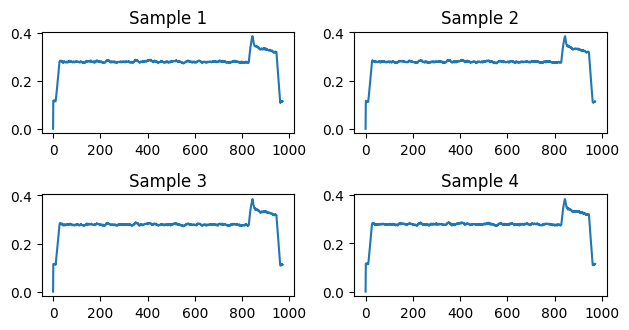

outlier signal (1000, 972)


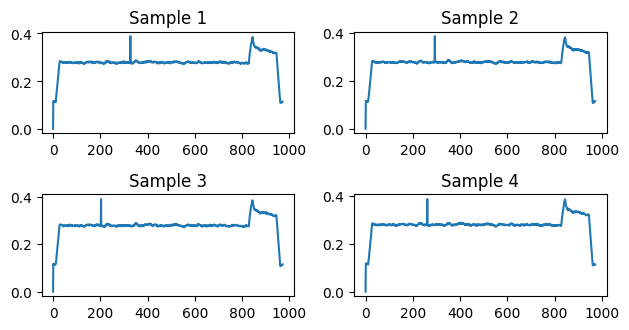

noise signal (1000, 972)


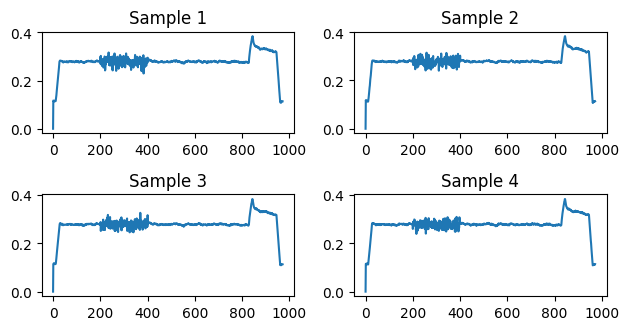

In [24]:
n_samples = 4
print('normal signal', normal_signal.shape)
check_signal_validity(normal_signal, n_samples)
print('outlier signal', outlier_signal_array.shape)
check_signal_validity(outlier_signal_array, n_samples)
print('noise signal', noise_signal_array.shape)
check_signal_validity(noise_signal_array, n_samples)

### 정상/비정상 신호 생성 기준

기본 신호 4개 기준, section은 3개로 전부 동일 (즉, 신호 1개당 3개 구간)

1. **정상 신호 (Normal Signal)**
   - 개수: 10,000 개

2. **이상치 신호 (Outlier Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호의 1.4배
   - 개수: 1 point

3. **노이즈 신호 (Noise Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호 + 신호 평균 * 0.05 scale을 갖는 정규분포

### Target columns 설명
1. **Target**
   - 0: 정상 신호
   - 1: 이상치 신호 (구간 1)
   - 2: 노이즈 신호 (구간 1)
   - 3: 이상치 신호 (구간 2)
   - 4: 노이즈 신호 (구간 2)
   - 5: 이상치 신호 (구간 3)
   - 6: 노이즈 신호 (구간 3)

2. **Section**
   - 구간 (순서대로 1, 2, 3)
   - signal 1: [(200, 400), (500, 700), (850, 940)]
   - signal 2: [(200, 800), (900, 950), (1030, 1080)]
   - signal 3: [(200, 500), (600, 750), (800, 900)]
   - signal 5: [(50, 200), (400, 1200), (1450, 1510)]

In [25]:
# data 만드는 기준 정보
n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 600

noise_ratio = 0.05
n_noise_samples = 600

target_normal = 0

In [26]:
total_dict = {}
for signal_idx, signal in base_signal_dict.items():
    normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
    row_data = np.copy(normal_signal)
    
    for section in base_signal_section[signal_idx]:
        signal = signal_dict[signal_idx]

        outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
        noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)
        
        row_data = np.vstack((row_data, outlier_signal_array, noise_signal_array))
    
    s = 0
    e = n_normal_samples

    df = pd.DataFrame(row_data)    
    df.loc[s:e, 'target'] = target_normal
    for i, v in enumerate(base_signal_section):
        s = e
        e = s+n_outlier_samples
        df.loc[s:e, 'target'] = i+1
        
        s = e
        e = s+n_noise_samples
        df.loc[s:e, 'target'] = i+4
        
    df['target'] = df['target'].astype(int)
    
    total_dict[signal_idx] = df

value_counts, bar plot, pie plot 이용, 개수 확인 결과 완료 (아래 코드 및 사진)

정상 신호: 10,000 개, 이상치 신호: 1,800 개 (구간 별 600 개), 노이즈 신호: 1,800 개 (구간 별 600 개)

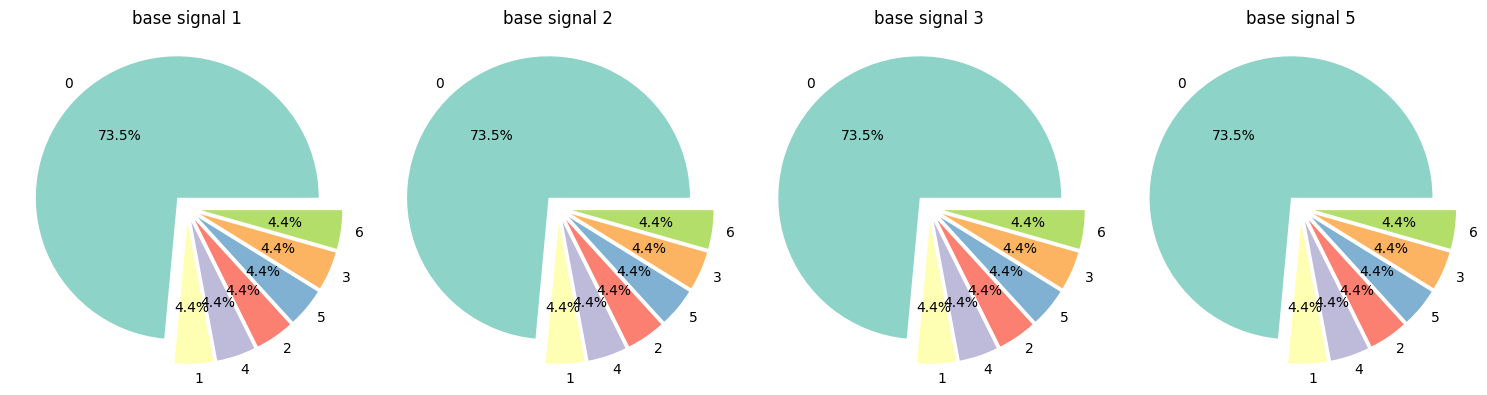

In [27]:
plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(total_dict.items(), start=1):
    plt.subplot(1, len(total_dict), i)
    
    counts = total_dict[key]['target'].value_counts()
    explode = [0.1] * len(counts)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode=explode, colors=cm.Set3.colors)
    plt.title(f'base signal {key}')
plt.tight_layout()
plt.show()

구간 별로 제대로 신호가 제대로 만들어졌는지 np.random.choice를 이용, 무작위로 뽑아 확인 결과 잘 만들어짐

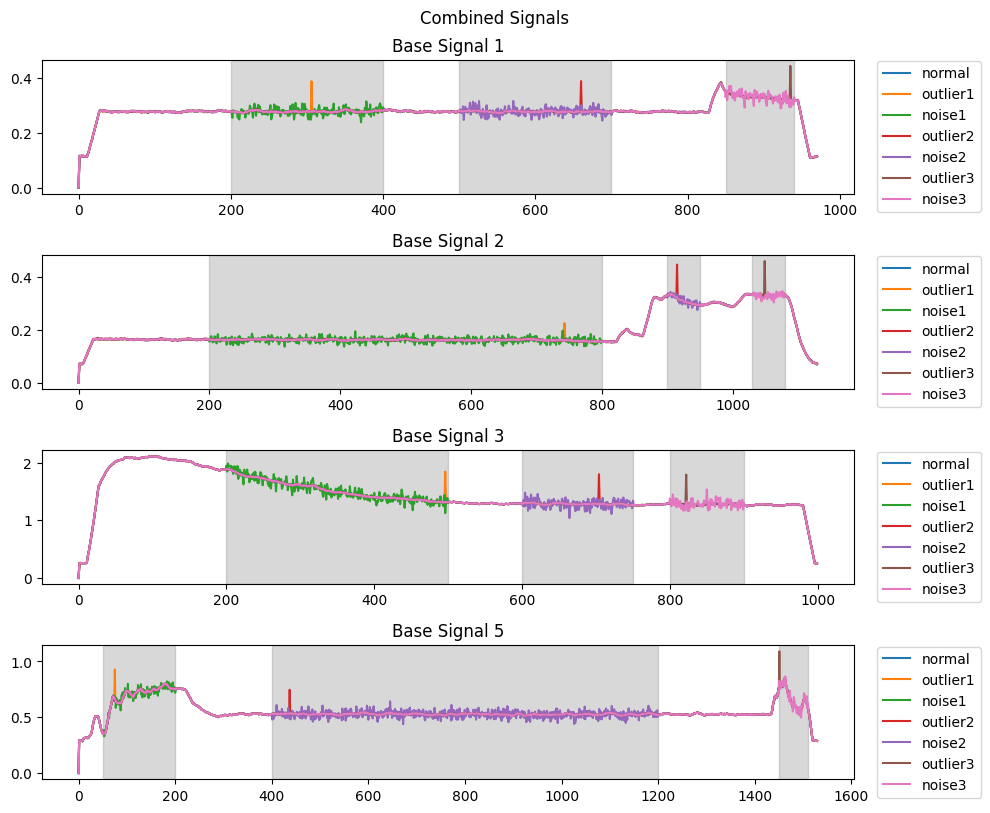

In [28]:
def generate_indices(start, end):
    return np.random.choice(range(start, end))

plt.figure(figsize=(10, 10))
plt.suptitle('Combined Signals')
for i, signal_idx in enumerate(base_signal_idx, start=1):
    signal_data = total_dict[signal_idx].iloc[:,:-2]
    normal = signal_data.iloc[generate_indices(0, 10000)]
    outlier1 = signal_data.iloc[generate_indices(10000, 10600)]
    noise1 = signal_data.iloc[generate_indices(10600, 11200)]
    outlier2 = signal_data.iloc[generate_indices(11200, 11800)]
    noise2 = signal_data.iloc[generate_indices(11800, 12400)]
    outlier3 = signal_data.iloc[generate_indices(12400, 13000)]
    noise3 = signal_data.iloc[generate_indices(13000, 13600)]

    plt.subplot(5, 1, i)
    plt.title(f'Base Signal {signal_idx}')
    plt.plot(normal, label='normal')
    plt.plot(outlier1, label='outlier1')
    plt.plot(noise1, label='noise1')
    plt.plot(outlier2, label='outlier2')
    plt.plot(noise2, label='noise2')
    plt.plot(outlier3, label='outlier3')
    plt.plot(noise3, label='noise3')
    for idx in base_signal_section[signal_idx]:
        plt.axvspan(xmin=idx[0], xmax=idx[1], color='gray', alpha=0.3)
    
    plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left')
plt.tight_layout()
plt.show()

만든 데이터를 csv 형태로 저장

- if not os.path.exists 코드는 Run All 할 떄마다 파일이 만들어지는데 100MB가 넘는 파일이라 오래 걸려 넣어 논 것

In [29]:
if not os.path.exists("./data/signal/data_1.csv"):
    for key, value in total_dict.items():
        filename = f"./data/signal/data_{key}.csv"
        value.to_csv(filename, index=False)

## 프로젝트 개요
플라즈마 이상 신호를 진단하기 위해 광 신호를 활용하는 센서를 개발 중입니다.

![플라즈마 이미지](image/project/plasma.jpg)

PMT 소자를 활용하여 플라즈마에서 방출된 photon을 electron으로 변환하여 세기를 측정하는 방식입니다.

데이터 형식은 1차원 배열로, 센서에서는 두 가지 형태의 데이터를 생성합니다:
1. **Streaming Data**: 초당 10,000,000 포인트를 생성합니다.
2. **Trend Data**: 초당 200 포인트를 생성하며, Streaming Data에서 최소값, 최대값, 평균을 50,000 포인트마다 샘플링하여 생성합니다.

현재 데이터의 양이 많아서 사람이 수동으로 데이터를 확인하고 있습니다.

두 데이터 모두 양이 많아서 사람이 수동으로 확인하기 어렵습니다.

이번 교육을 통해 머신러닝/딥러닝을 활용하여 센서 데이터를 학습하여 진단 결과를 도출하는 모델을 개발하고자 합니다.

---
## **기획**


 ### <기획 가이드>
> #### 현업 적용 문제 정의
(공유 가능한 선에서 업무를 소개해 주세요)
- **요구사항 확인 :** 현업에서의 분석 요구사항, 요구사항이 나오게 된 배경 등 과 같은 실제 현업의 문제점 작성.
- **문제 범위 설정 :** 인텐시브 과정 내 가능한 수준인가, 분석 범위 및 계획 등과 같은 범위를 설정.
- **문제 정의 도출 :** 위 내용을 바탕으로 해결하고 싶은 문제(가설) 정의.<br> (main 정의 후 main을 해결하기 위한 sub 문제 2-3개)

> #### 데이터 수집 방안 및 사용 데이터 정의
- **데이터 확보 방법 :** 사내 DB 추출, 웹데이터 크롤링 등 확보 방법을 작성해 주세요.
- **활용 데이터 정의 :** 데이터 소스(사내 시스템명, 외부 사이트 URL 등), 데이터 유형(정형, 비정형_텍스트, 이미지, 영상 등), Feature, 형태(확장자, shape, size, count) 등 데이터에 관한 설명<br>

> #### 분석 방향 설정
- **분석 시 예상되는 어려움 :** 논리적 추론을 통해 문제를 해결해 나가는 과정에서 짐작되는 어려운 부분을 작성.
- **문제 해결을 위한 모델 사용 방법 :** 문제에 적합한 모델을 어떻게 구성해 나갈 것인지 작성.

### [배경 설명 & 요구사항 확인]

배경: 온라인 쇼핑몰에서 고객의 구매 이력 데이터를 분석하여 고객별 맞춤형 상품 추천을 제공하고자 합니다.

요구사항 확인: 고객의 구매 패턴을 분석하고, 고객별로 관심 있을 만한 상품을 추천하여 구매 전환율을 높이고자 합니다.

### [문제 범위 설정]

분석 범위는 지난 1년간의 구매 이력 데이터를 활용하여 주요 구매 패턴을 식별하고, 상품 추천 알고리즘을 개발하는 것으로 합니다.

### [문제 정의 도출]

Main 문제 정의: 고객별 구매 이력 데이터를 바탕으로 개인화된 상품 추천 모델을 개발합니다.

Sub 문제:

고객의 구매 패턴 식별

추천 시스템의 정확도 향상

추천 시스템의 다양성 및 새로움 증가

### [데이터 확보 방법]

데이터 확보 방법: 사내 DB에서 고객의 구매 이력, 상품 정보, 고객 행동 로그 데이터를 추출합니다.

---
데이터 확보 방법: 자체 개발 중인 사내 센서 SSD에 남는 플라즈마 광 신호 데이터를 추출합니다.

### [활용 데이터 정의]

데이터 소스: 사내 DB

데이터 유형: 정형 데이터(구매 이력, 상품 정보)

Feature: 고객 ID, 상품 ID, 구매 날짜, 가격, 카테고리 등

형태: CSV 파일, 각 파일은 수만 건의 레코드를 포함

### [분석시 예상되는 어려움]

고객별 데이터의 불균형이 심각하여 일부 고객에 대한 과적합이 발생할 수 있습니다.

### [문제 해결을 위한 모델 사용 방법]

협업 필터링과 콘텐츠 기반 필터링을 결합한 하이브리드 추천 시스템을 구현합니다.

---
## **준비**

### <준비 가이드>
#### 데이터 수집 및 로드
- 문제 해결에 필요한 데이터를 수집 및 로드.

#### 데이터 전처리
- 결측치 처리, 이상치 처리, feature scale 등 데이터 정제.
- 데이터의 품질을 향상시키는 것이 중요.

### [데이터 수집 및 로드]

사내 DB에서 SQL 쿼리를 사용하여 고객 구매 이력, 상품 정보, 고객 행동 로그 데이터를 추출합니다.
데이터는 CSV 형식으로 저장되며, Python의 pandas 라이브러리를 사용하여 로드합니다.

In [39]:
import pandas as pd

df_1 = pd.read_csv('./data/signal/data_1.csv')
df_2 = pd.read_csv('./data/signal/data_2.csv')
df_3 = pd.read_csv('./data/signal/data_3.csv')
df_5 = pd.read_csv('./data/signal/data_5.csv')

### [데이터 전처리]

결측치는 해당 필드의 평균값(연속형 변수)이나 최빈값(범주형 변수)으로 대체합니다.
이상치는 IQR(Interquartile Range) 방법을 사용하여 식별하고 처리합니다.
모든 수치형 변수는 스케일링을 통해 정규화합니다.

In [31]:
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import numpy as np

# # 결측치 처리
# customer_purchase.fillna(customer_purchase.mean(), inplace=True)

# # 이상치 처리
# Q1 = customer_purchase.quantile(0.25)
# Q3 = customer_purchase.quantile(0.75)
# IQR = Q3 - Q1
# customer_purchase = customer_purchase[~((customer_purchase < (Q1 - 1.5 * IQR)) |(customer_purchase > (Q3 + 1.5 * IQR))).any(axis=1)]

# # 스케일링
# scaler = StandardScaler()
# customer_purchase_scaled = scaler.fit_transform(customer_purchase.select_dtypes(include=[np.number]))

---
## **EDA**

### <EDA 가이드>
- 데이터의 구조, 패턴, 이상치, 상관 관계 등을 파악
- 시각화 도구를 사용하여 데이터를 분석
- 모델의 성능을 향상시키기 위해 피처를 선택, 변환, 생성
- 데이터의 정보를 최대한 활용

matplotlib과 seaborn 라이브러리를 사용하여 데이터의 분포, 상관 관계를 시각화합니다.
고객의 구매 패턴, 상품 카테고리별 판매량 등 주요 인사이트를 도출합니다.

In [32]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 고객별 구매 빈도 시각화
# customer_purchase_frequency = customer_purchase['customer_id'].value_counts()
# sns.histplot(customer_purchase_frequency, kde=True)
# plt.title('Customer Purchase Frequency')
# plt.xlabel('Number of Purchases')
# plt.ylabel('Frequency')
# plt.show()

# # 상품 카테고리별 판매량
# sns.countplot(data=product_info, x='category')
# plt.title('Sales by Product Category')
# plt.xticks(rotation=45)
# plt.ylabel('Number of Sales')
# plt.show()

위 시각화 결과를 통해 다음과 같은 패턴을 확인할 수 있었습니다.

`bill_length_mm`과 `bill_depth_mm`로 Scatter plot를 그려볼 시 각 종별로 일부 데이터를 제외하고 군집이 잘 형성됨을 확인하였습니다.

- **Adelie:** 다른 펭귄 보다 bill_length가 작고, Chinstrap 펭귄과  bill_depth가 비슷하게 분포한다.
- **Chinstrap:** Adelie 펭귄 보다 bill_length가 크고, Gentoo 펭귄과 bill_depth가 비슷하게 분포한다.
- **Gentoo:**  Chinstrap 펭귄과 bill_length가 비슷하고, 다른 펭귄 보다 bill_depth가 작게 분포한다.


종과 상관없이 수컷 팽귄의 `bill_length`와 `bill_depth`이 암컷보다 선형적으로 커진다는 것을 확인할 수 있었으며,
<br>`body_mass`를 통해 Gentoo 펭귄이 다른 종보다 큰 몸집을 갖는다는 것을 확인하였습니다.

이 내용을 기반으로 종별 bill_length, bill_depth 등 각 컬럼의 Number Summary를 확인 하고자 합니다.

---
## **모델**

### <모델 가이드>
- 문제에 적합한 머신러닝 알고리즘을 선택
- 모델을 훈련하고 최적화
- 모델의 성능을 평가(정확도, 정밀도, 재현율, F1 점수 등 다양한 지표를 사용)

고객의 구매 이력을 기반으로 하는 협업 필터링 모델을 구현합니다.
scikit-learn 라이브러리를 사용하여 훈련 데이터와 테스트 데이터를 분할하고, 모델을 훈련 및 평가합니다.

In [33]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier

# # 데이터 준비
# X = customer_behavior.drop('purchase', axis=1)
# y = customer_behavior['purchase']

# # 데이터 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 모델 훈련 및 평가
# model = RandomForestClassifier(n_estimators=100000000, random_state=420000000)
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)

# print(f"Accuracy: {accuracy_score(y_test, predictions)}")

---
## **결론**

### <결론 가이드>
- 처음 정의한 문제 해결
- 문제와 관련된 새로운 사실
- 기존 업무 효율화
- 데이터셋에 대한 인사이트
- 등등

여러 관점에서 프로젝트의 결과를 정리하여 최종 결론을 논리적으로 서술

추천 시스템을 통해 구매 전환율이 예상보다 X% 향상될 것으로 예측합니다.

추가 데이터 수집 및 다른 알고리즘의 적용 가능성에 대해서도 탐색합니다.

더 정밀한 타겟팅과 개인화된 추천을 위해, 향후에는 고급 기법들을 도입할 계획입니다. 예를 들어, 딥러닝 기반의 추천 시스템이나, 시간에 따라 변화하는 고객의 선호를 반영할 수 있는 동적 모델링 방법들입니다.

이 프로젝트를 통해 얻은 인사이트와 모델은 실제 업무 프로세스에 통합될 예정입니다. 예를 들어, 마케팅 캠페인의 타겟팅 전략 수립, 재고 관리 및 물류 계획의 최적화, 신제품 개발의 방향성 결정 등 다양한 분야에서 활용될 수 있습니다.
또한, 프로젝트 결과는 내부 리포트와 워크숍을 통해 공유되어, 조직 전반의 데이터 기반 의사결정 문화를 강화하는 데 기여할 것입니다.